# Goal

To produce a file which contains all collaborative relationships between coauthors. I have ~75k publications from our 1041 CHW authors, where each publication contains a list of coauthors.

I need to get all pairwise relationships between the coauthors and a list of all unique CHW authors.

In [1]:
import numpy as np
import pandas as pd
import utils.misc as um
import itertools

In [4]:
df = pd.read_csv('dec14_pca_results.csv', index_col = 0)

# df = df_auths[df_auths['affil'] == 'ACHRI']
print(df.columns[:35])
df.info()
df.head()

Index(['citation_count', 'cited_by_count', 'coauthor_count',
       'classificationgroup', 'document_count', 'h_index', 'indexed_name',
       'subject_areas', 'Auid', 'total_current_affiliations',
       'total_past_affiliations', 'first_publication', 'last_publication',
       'publication_duration', 'ORCID', 'CHW author', 'author_count median',
       'author_count mean', 'citedby_count sum', 'openaccess sum',
       'chw_author_position median', 'chw_author_position mean',
       'first_author sum', 'last_author sum', 'author_weight median',
       'author_weight mean', 'Article sum', 'Book sum', 'Book Chapter sum',
       'Chapter sum', 'Conference Paper sum', 'Data Paper sum',
       'Editorial sum', 'Erratum sum', 'Letter sum'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2490 entries, 1 to 2490
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   citati

,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,h_index,indexed_name,subject_areas,Auid,total_current_affiliations,...,SJR median,SJR mean,journal_h_index median,journal_h_index mean,affil,scores.PC1,scores.PC2,scores.PC3,scores.PC4,scores.PC5
1,2219,1661,516,"[(1303, 1), (1313, 6), (2737, 1), (1311, 11), ...",96,22,Rassekh S.,"[Subjectarea(area='Biochemistry', abbreviation...",6503856044,1,...,1.1160,2.129307,105.0,145.44318,BCCHR,-0.676523,0.412204,-0.118775,0.143272,-0.115172
2,1314,1043,129,"[(1300, 5), (2712, 2), (1109, 1), (2808, 1), (...",32,16,Provençal N.,"[Subjectarea(area='Biochemistry, Genetics and ...",6503905253,2,...,1.7790,2.286880,186.0,223.68000,BCCHR,-0.028339,-0.248274,-0.311486,0.032425,-0.076650
3,590,582,293,"[(2740, 1), (2906, 1), (2746, 1), (2919, 1), (...",21,12,Hendson L.,[Subjectarea(area='Pulmonary and Respiratory M...,6503911165,1,...,1.0820,1.509500,120.5,171.75000,ACHRI,1.068288,-1.451969,0.718854,-0.045161,-0.091165
4,302,272,49,"[(2746, 7), (2735, 7), (2726, 1), (1707, 1), (...",14,7,Himidan S.,"[Subjectarea(area='Surgery', abbreviation='MED...",6504203692,2,...,0.8925,0.760800,98.0,93.80000,Sickkids,1.644291,-1.622377,-0.444649,0.039848,-0.049216
5,294,282,100,"[(2800, 2), (2723, 1), (2701, 1), (2746, 13), ...",35,10,Ramien M.,"[Subjectarea(area='Neuroscience (all)', abbrev...",6504324290,2,...,0.5930,1.158514,60.0,99.77143,ACHRI,1.410638,0.365704,-0.019008,-0.067610,0.027814


In [8]:
df.rename(columns = {'Auid': 'Id', 'scores.PC1': 'PC1'}, inplace = True)

# standardize PC1 scores to unit interval
df['PC1_norm'] = -1*(df['PC1'] - df['PC1'].min())/(df['PC1'].max() - df['PC1'].min()) + 1

# get nodes
nodes = df[['Id', 'affil', 'PC1', 'PC1_norm']]
nodes.to_excel('../Datasets/graph_nodes_dec14.xlsx', index = False)

In [5]:
df_pubs = pd.read_csv('../Datasets/chw_publications.csv')
df_pubs.info()
print(df_pubs.columns[:25])
df_pubs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219997 entries, 0 to 219996
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CHW author           219997 non-null  int64  
 1   eid                  219997 non-null  object 
 2   doi                  205160 non-null  object 
 3   pii                  59958 non-null   object 
 4   pubmed_id            179365 non-null  float64
 5   title                219989 non-null  object 
 6   subtype              219997 non-null  object 
 7   subtypeDescription   219913 non-null  object 
 8   creator              219890 non-null  object 
 9   afid                 213954 non-null  object 
 10  affilname            213954 non-null  object 
 11  affiliation_city     213608 non-null  object 
 12  affiliation_country  213908 non-null  object 
 13  author_count         219929 non-null  float64
 14  author_names         219929 non-null  object 
 15  author_ids       

,CHW author,eid,doi,pii,pubmed_id,title,subtype,subtypeDescription,creator,afid,...,issueIdentifier,article_number,pageRange,description,authkeywords,citedby_count,openaccess,fund_acr,fund_no,fund_sponsor
0,6503856044,2-s2.0-85102936784,10.1177/10935266211001986,NaN,33749384.0,Histologic Correlates of Molecular Group 4 Ped...,re,Review,Triscott J.,60193402;60023077;60020486;60018471;60010365;1...,...,4,NaN,309-317,Introduction: The World Health Organization cu...,biphasic | histology | molecular subtypes | Na...,1,0,MSFHR,undefined,Hannah's Heroes Foundation
1,6503856044,2-s2.0-85108228079,10.2217/pme-2020-0120,NaN,33973801.0,Deliberations about clinical pharmacogenetic t...,re,Review,Issa A.M.,60191838;60086967;60030835;60029502;60026553;6...,...,4,NaN,399-405,"This article summarizes the background, conten...",adverse reactions | deliberative consultation ...,0,0,CIHR,1-155872,Genome Canada
2,6503856044,2-s2.0-85104934944,10.1002/cam4.3910,NaN,33939292.0,Trametinib therapy for children with neurofibr...,ar,Article,Ronsley R.,60023077;60010365,...,11,NaN,3556-3564,Purpose: To describe a series of children with...,low-grade glioma | neurofibromatosis | pediatr...,1,1,NaN,undefined,NaN
3,6503856044,2-s2.0-85109755328,10.9778/cmajo.20200212,NaN,34021014.0,Family attitudes about and experiences with me...,ar,Article,Gibbard M.,60086967,...,2,NaN,E563-E569,BACKGROUND: Cannabis is legal for recreational...,NaN,2,1,NaN,undefined,NaN
4,6503856044,2-s2.0-85101694285,10.1016/S2352-4642(21)00020-1,S2352464221000201,33581749.0,Prevalence and risk factors for cisplatin-indu...,ar,Article,Moke D.J.,60086967;60030769;60029311;60023077;60020565;6...,...,4,NaN,274-283,Background: Cisplatin is used to treat a wide ...,NaN,5,0,NIH,P30CA014089,National Institutes of Health


In [6]:
# get only publications after 2016
df_pubs['Year'] = df_pubs['coverDate'].str.extract('^([0-9]*)-')

df_pubs['Year'] = df_pubs['Year'].apply(int)

df_pubs = df_pubs[df_pubs['Year'] >= 2016]
df_pubs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79474 entries, 0 to 219996
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CHW author           79474 non-null  int64  
 1   eid                  79474 non-null  object 
 2   doi                  78364 non-null  object 
 3   pii                  20291 non-null  object 
 4   pubmed_id            64470 non-null  float64
 5   title                79474 non-null  object 
 6   subtype              79474 non-null  object 
 7   subtypeDescription   79393 non-null  object 
 8   creator              79417 non-null  object 
 9   afid                 78250 non-null  object 
 10  affilname            78250 non-null  object 
 11  affiliation_city     78209 non-null  object 
 12  affiliation_country  78242 non-null  object 
 13  author_count         79450 non-null  float64
 14  author_names         79450 non-null  object 
 15  author_ids           79450 non-null

In [7]:
def convert_to_int(x):
    """ Take x, possibly a list, and convert to int """
    try:
        if isinstance(x, list):
            return [int(i) for i in x]
        elif np.isnan(x):
            return 0
        else:
            return int(x)
        
    except:
        raise

In [8]:
df_pubs.loc[:, 'auids'] = df_pubs.loc[:, 'author_ids'].str.split(';')

# remove any missing rows
df_pubs = df_pubs[~df_pubs.author_ids.isna()]

# convert auids to int
df_pubs['auids'] = df_pubs['auids'].apply(um.convert_to_int)

In [9]:
# get the chw author positions - come back to see the ones not found in their own author lists
not_found = []

for i in df_pubs.index:
    try:
        df_pubs.loc[i, 'chw_author_position'] = df_pubs.loc[i, 'auids'].index(df_pubs.loc[i, 'CHW author'])
    except ValueError:
        not_found.append(i)
        
print('{} authors not found in their own author lists\n'.format(len(not_found)))

df_pubs.head()

700 authors not found in their own author lists



,CHW author,eid,doi,pii,pubmed_id,title,subtype,subtypeDescription,creator,afid,...,description,authkeywords,citedby_count,openaccess,fund_acr,fund_no,fund_sponsor,Year,auids,chw_author_position
0,6503856044,2-s2.0-85102936784,10.1177/10935266211001986,NaN,33749384.0,Histologic Correlates of Molecular Group 4 Ped...,re,Review,Triscott J.,60193402;60023077;60020486;60018471;60010365;1...,...,Introduction: The World Health Organization cu...,biphasic | histology | molecular subtypes | Na...,1,0,MSFHR,undefined,Hannah's Heroes Foundation,2021,"[53882034800, 7102134322, 7403550284, 71018199...",4.0
1,6503856044,2-s2.0-85108228079,10.2217/pme-2020-0120,NaN,33973801.0,Deliberations about clinical pharmacogenetic t...,re,Review,Issa A.M.,60191838;60086967;60030835;60029502;60026553;6...,...,"This article summarizes the background, conten...",adverse reactions | deliberative consultation ...,0,0,CIHR,1-155872,Genome Canada,2021,"[7006615788, 57200159420, 6603414671, 36980983...",5.0
2,6503856044,2-s2.0-85104934944,10.1002/cam4.3910,NaN,33939292.0,Trametinib therapy for children with neurofibr...,ar,Article,Ronsley R.,60023077;60010365,...,Purpose: To describe a series of children with...,low-grade glioma | neurofibromatosis | pediatr...,1,1,NaN,undefined,NaN,2021,"[35272975600, 57204041913, 54388707200, 650385...",3.0
3,6503856044,2-s2.0-85109755328,10.9778/cmajo.20200212,NaN,34021014.0,Family attitudes about and experiences with me...,ar,Article,Gibbard M.,60086967,...,BACKGROUND: Cannabis is legal for recreational...,NaN,2,1,NaN,undefined,NaN,2021,"[57224506700, 57209177557, 6503856044, 6506014...",2.0
4,6503856044,2-s2.0-85101694285,10.1016/S2352-4642(21)00020-1,S2352464221000201,33581749.0,Prevalence and risk factors for cisplatin-indu...,ar,Article,Moke D.J.,60086967;60030769;60029311;60023077;60020565;6...,...,Background: Cisplatin is used to treat a wide ...,NaN,5,0,NIH,P30CA014089,National Institutes of Health,2021,"[57194505277, 57205079186, 24367129900, 162306...",4.0


In [10]:
# reduce the number of columns
df2 = df_pubs[['CHW author', 'eid', 'citedby_count', 'auids', 'chw_author_position', 'Year']]
df2

,CHW author,eid,citedby_count,auids,chw_author_position,Year
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021
1,6503856044,2-s2.0-85108228079,0,"[7006615788, 57200159420, 6603414671, 36980983...",5.0,2021
2,6503856044,2-s2.0-85104934944,1,"[35272975600, 57204041913, 54388707200, 650385...",3.0,2021
3,6503856044,2-s2.0-85109755328,2,"[57224506700, 57209177557, 6503856044, 6506014...",2.0,2021
4,6503856044,2-s2.0-85101694285,5,"[57194505277, 57205079186, 24367129900, 162306...",4.0,2021
...,...,...,...,...,...,...
219992,57220999344,2-s2.0-85097982774,1,"[55062176700, 56568449600, 56037870400, 572021...",4.0,2021
219993,57226726716,2-s2.0-85112413672,0,"[57225302207, 56196397400, 57226709101, 571893...",5.0,2021
219994,57241564300,2-s2.0-85100438652,0,"[35739201900, 57241564300]",1.0,2021
219995,57249145700,2-s2.0-85114437047,0,"[57220589090, 57218249433, 55192953600, 572491...",3.0,2021


In [11]:
# get the positions of each author in the list of auids
df2['coauthor_position'] = df2['auids'].apply(lambda x: list(enumerate(x)))
df2

/home/matt/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,CHW author,eid,citedby_count,auids,chw_author_position,Year,coauthor_position
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"[(0, 53882034800), (1, 7102134322), (2, 740355..."
1,6503856044,2-s2.0-85108228079,0,"[7006615788, 57200159420, 6603414671, 36980983...",5.0,2021,"[(0, 7006615788), (1, 57200159420), (2, 660341..."
2,6503856044,2-s2.0-85104934944,1,"[35272975600, 57204041913, 54388707200, 650385...",3.0,2021,"[(0, 35272975600), (1, 57204041913), (2, 54388..."
3,6503856044,2-s2.0-85109755328,2,"[57224506700, 57209177557, 6503856044, 6506014...",2.0,2021,"[(0, 57224506700), (1, 57209177557), (2, 65038..."
4,6503856044,2-s2.0-85101694285,5,"[57194505277, 57205079186, 24367129900, 162306...",4.0,2021,"[(0, 57194505277), (1, 57205079186), (2, 24367..."
...,...,...,...,...,...,...,...
219992,57220999344,2-s2.0-85097982774,1,"[55062176700, 56568449600, 56037870400, 572021...",4.0,2021,"[(0, 55062176700), (1, 56568449600), (2, 56037..."
219993,57226726716,2-s2.0-85112413672,0,"[57225302207, 56196397400, 57226709101, 571893...",5.0,2021,"[(0, 57225302207), (1, 56196397400), (2, 57226..."
219994,57241564300,2-s2.0-85100438652,0,"[35739201900, 57241564300]",1.0,2021,"[(0, 35739201900), (1, 57241564300)]"
219995,57249145700,2-s2.0-85114437047,0,"[57220589090, 57218249433, 55192953600, 572491...",3.0,2021,"[(0, 57220589090), (1, 57218249433), (2, 55192..."


In [12]:
# explode the 'coauthor_position' column
df2 = df2.explode('coauthor_position')
df2.head()

,CHW author,eid,citedby_count,auids,chw_author_position,Year,coauthor_position
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(0, 53882034800)"
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(1, 7102134322)"
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(2, 7403550284)"
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(3, 7101819941)"
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(4, 6503856044)"


In [13]:
# get the coauthor positions and auids
df2['Target_position'] = df2['coauthor_position'].apply(lambda x: x[0])
df2['Target'] = df2['coauthor_position'].apply(lambda x: x[1])
df2.head()

,CHW author,eid,citedby_count,auids,chw_author_position,Year,coauthor_position,Target_position,Target
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(0, 53882034800)",0,53882034800
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(1, 7102134322)",1,7102134322
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(2, 7403550284)",2,7403550284
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(3, 7101819941)",3,7101819941
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(4, 6503856044)",4,6503856044


In [14]:
# find the distance between authors
df2['coauthor_distance'] = np.abs(df2['chw_author_position'] - df2['Target_position'])
df2.head()

,CHW author,eid,citedby_count,auids,chw_author_position,Year,coauthor_position,Target_position,Target,coauthor_distance
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(0, 53882034800)",0,53882034800,4.0
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(1, 7102134322)",1,7102134322,3.0
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(2, 7403550284)",2,7403550284,2.0
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(3, 7101819941)",3,7101819941,1.0
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(4, 6503856044)",4,6503856044,0.0


In [15]:
# reset the index
df2.index = np.arange(len(df2))

# rename the 'CHW author' column
df2.rename(
    columns = {
        'CHW author': 'Source'
    },
    inplace = True
)

In [27]:
# drop the unused columns
edges = df2.drop(
    [
        'auids',
        'chw_author_position',
        'coauthor_position',
        'Target_position',
        'eid'
    ],
    axis = 1
)

In [28]:
edges

,Source,citedby_count,Year,Target,coauthor_distance
0,6503856044,1,2021,53882034800,4.0
1,6503856044,1,2021,7102134322,3.0
2,6503856044,1,2021,7403550284,2.0
3,6503856044,1,2021,7101819941,1.0
4,6503856044,1,2021,6503856044,0.0
...,...,...,...,...,...
981749,57283733600,0,2021,57284830400,2.0
981750,57283733600,0,2021,57193198855,3.0
981751,57283733600,0,2021,7102290275,4.0
981752,57283733600,0,2021,7401509446,5.0


In [29]:
# reorder the columns
edges = edges[['Source', 'Target', 'citedby_count', 'coauthor_distance', 'Year']]

# take out self-connections
edges = edges[edges['Source'] != edges['Target']]

# transform the skewed columns
edges['log_citations'] = edges['citedby_count'].apply(lambda x: np.log(x + 1))
edges['log_distance'] = edges['coauthor_distance'].apply(lambda x: np.log(x + 1))

# get edge weights - using a Gaussian for now
sigma = 1
edges['Weight'] = np.exp(-(edges['log_distance']**2/sigma))*edges['log_citations']
edges.head()

,Source,Target,citedby_count,coauthor_distance,Year,log_citations,log_distance,Weight
0,6503856044,53882034800,1,4.0,2021,0.693147,1.609438,0.051985
1,6503856044,7102134322,1,3.0,2021,0.693147,1.386294,0.101436
2,6503856044,7403550284,1,2.0,2021,0.693147,1.098612,0.207326
3,6503856044,7101819941,1,1.0,2021,0.693147,0.693147,0.428714
5,6503856044,6603195101,1,1.0,2021,0.693147,0.693147,0.428714


In [30]:
# normalize weights to interval (0,1)
edges['Weight'] = (edges['Weight'] - edges['Weight'].min())/(edges['Weight'].max() - edges['Weight'].min())

/home/matt/anaconda3/envs/main/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


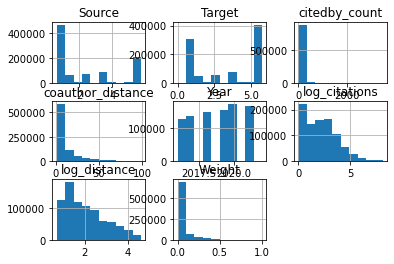

In [31]:
edges.hist();

In [32]:
nodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2490 entries, 1 to 2490
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      2490 non-null   int64  
 1   affil   2490 non-null   object 
 2   PC1     2490 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 77.8+ KB


In [33]:
df3 = pd.merge(edges, nodes, left_on = 'Source', right_on = 'Id').drop('Id', axis = 1)
df3

,Source,Target,citedby_count,coauthor_distance,Year,log_citations,log_distance,Weight,affil,PC1
0,6503856044,53882034800,1,4.0,2021,0.693147,1.609438,0.010309,BCCHR,0.427345
1,6503856044,7102134322,1,3.0,2021,0.693147,1.386294,0.020115,BCCHR,0.427345
2,6503856044,7403550284,1,2.0,2021,0.693147,1.098612,0.041114,BCCHR,0.427345
3,6503856044,7101819941,1,1.0,2021,0.693147,0.693147,0.085017,BCCHR,0.427345
4,6503856044,6603195101,1,1.0,2021,0.693147,0.693147,0.085017,BCCHR,0.427345
...,...,...,...,...,...,...,...,...,...,...
862952,57283733600,57284830400,0,2.0,2021,0.000000,1.098612,0.000000,McMaster,0.758567
862953,57283733600,57193198855,0,3.0,2021,0.000000,1.386294,0.000000,McMaster,0.758567
862954,57283733600,7102290275,0,4.0,2021,0.000000,1.609438,0.000000,McMaster,0.758567
862955,57283733600,7401509446,0,5.0,2021,0.000000,1.791759,0.000000,McMaster,0.758567


In [35]:
df3.to_csv('../Datasets/graph_edges_dec11.csv', index = False)

In [41]:
df_nodes2 = pd.read_csv('../Datasets/nodes_from_edges.csv')
df_nodes2.info()
df_nodes2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137465 entries, 0 to 137464
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Id       137465 non-null  int64  
 1   Label    0 non-null       float64
 2   timeset  0 non-null       float64
dtypes: float64(2), int64(1)
memory usage: 3.1 MB


,Id,Label,timeset
0,55507112000,NaN,NaN
1,24345434200,NaN,NaN
2,53981702600,NaN,NaN
3,57191588150,NaN,NaN
4,57224137177,NaN,NaN


In [42]:
merged_nodes = pd.merge(left = df_nodes2, right = nodes, left_on = 'Id', right_on = 'Id')

In [43]:
merged_nodes.info()
merged_nodes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1982 entries, 0 to 1981
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       1982 non-null   int64  
 1   Label    0 non-null      float64
 2   timeset  0 non-null      float64
 3   affil    1982 non-null   object 
 4   PC1      1982 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 92.9+ KB


,Id,Label,timeset,affil,PC1
0,54780793500,NaN,NaN,BCCHR,0.488363
1,35748384000,NaN,NaN,ACHRI,0.672679
2,55334458200,NaN,NaN,WCHRI,0.520321
3,6701324598,NaN,NaN,ACHRI,0.568638
4,36163230000,NaN,NaN,CHRIM,0.599353


In [24]:
merged_nodes['Label'] = merged_nodes['affil']

In [25]:
merged_nodes.to_csv('../Datasets/nodes_with_affil.csv', index = False)